## SHORT TERM DAILY FORECASTING - CLUSTERING + FEDERATED DNN APPROACH

TRAINING OF THE SEQUENTIAL MODELS IN FEDERATED SETUP


In [1]:
#@test {"skip": true}

# Install or upgrade TensorFlow Federated library
!pip install --quiet --upgrade tensorflow-federated

In [2]:
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

# Set a random seed for reproducibility
np.random.seed(0)

# Test the installation of TensorFlow Federated
tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

In [6]:
# Mount Google Drive to access the data file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd

# Load the data from the CSV file into a Pandas DataFrame
data = pd.read_csv('/content/drive/MyDrive/LAB3-20221109T160610Z-001/LCL-FullData/Cluster9data.csv')

In [5]:
# Convert the 'DateTime' column to datetime objects
data['DateTime'] = pd.to_datetime(data['DateTime'])

# Filter the DataFrame to include readings from 2011 to 2013
start_date1 = pd.to_datetime('2011-10-01')
end_date1 = pd.to_datetime('2013-02-28')
filtered_data1 = data[(data['DateTime'] >= start_date1) & (data['DateTime'] <= end_date1)]

In [7]:
# Select 20 unique LCLids
lclid_list1 = filtered_data1['LCLid'].unique()
selected_lclids1 = lclid_list1[:20]  # Select the first 20 unique LCLids

# Filter data for the selected LCLids
f_data1 = filtered_data1[filtered_data1['LCLid'].isin(selected_lclids1)]

# Create a copy of the filtered data for processing
datan1 = f_data1.copy()

# Convert the 'KWH/hh' column to float32 data type
datan1['KWH/hh'] = datan1['KWH/hh'].astype(np.float32)

# Drop the 'cluster' and 'stdorToU' columns from the DataFrame
datan1 = datan1.drop('cluster', axis=1)
datan1 = datan1.drop('stdorToU', axis=1)

# Reset the DataFrame index after dropping columns
datan1.reset_index(drop=True, inplace=True)

In [10]:
# Convert 'DateTime' column to datetime objects and remove timezone information
datan1['DateTime'] = pd.to_datetime(datan1['DateTime']).dt.tz_localize(None)

# Convert 'DateTime' to timestamp (Unix time in seconds) for each row
for i in range(len(datan1)):
    datan1['DateTime'][i] = datan1['DateTime'][i].timestamp()

# Convert 'DateTime' column to float32 data type
datan1['DateTime'] = datan1['DateTime'].astype(np.float32)

# Sort the data by 'LCLid' and 'DateTime' in ascending order
datan1.sort_values(['LCLid', 'DateTime'], inplace=True)


<ipython-input-10-b59380e28e58>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datan1['DateTime'][i]=datan1['DateTime'][i].timestamp()


In [13]:
import collections

# Define the client window dataset function for a specific LCLid
def create_client_dataset_for_LCLid(client_data, window_size, step_size):
    client_windows = []    # List to store the input windows for the client
    client_targets = []    # List to store the target values for each window
    num_readings = len(client_data)    # Total number of readings for the client

    # Iterate over the readings using the sliding window
    for i in range(0, num_readings - window_size, step_size):
        window_start = i    # Start index of the window
        window_end = i + window_size - 1    # End index of the window
        prediction_index = window_end + step_size    # Index of the target value for the window

        # Extract the window and the prediction target
        window = client_data.iloc[window_start:window_end + 1]['KWH/hh'].values
        target = client_data.iloc[prediction_index]['KWH/hh']

        # Append the window and target to their respective lists
        client_windows.append(window)
        client_targets.append(target)

    # Create an ordered dictionary with 'x' and 'y' keys
    ordered_dict = collections.OrderedDict()
    ordered_dict['x'] = tf.stack(client_windows)    # Stack the windows as a tensor
    ordered_dict['y'] = tf.expand_dims(client_targets, axis=-1)    # Expand dimensions of target for compatibility

    return ordered_dict

In [14]:
# Define the window_size and step_size
window_size = 336
step_size = 1

# Filter the dataframe for the specific LCLid
example_LCLid = datan1['LCLid'].unique()[3]
clientyy_data = datan1[datan1['LCLid'] == example_LCLid]

# Create the client dataset for the specific LCLid
example_client_dataset = create_client_dataset_for_LCLid(clientyy_data, window_size, step_size)

# Print the results
print("Client dataset for LCLid", example_LCLid)
print(example_client_dataset)


Client dataset for LCLid MAC000056
OrderedDict([('x', <tf.Tensor: shape=(21105, 336), dtype=float32, numpy=
array([[0.064, 0.251, 0.134, ..., 0.03 , 0.003, 0.005],
       [0.251, 0.134, 0.185, ..., 0.003, 0.005, 0.006],
       [0.134, 0.185, 0.255, ..., 0.005, 0.006, 0.06 ],
       ...,
       [0.033, 0.055, 0.055, ..., 0.143, 0.065, 0.094],
       [0.055, 0.055, 0.071, ..., 0.065, 0.094, 0.075],
       [0.055, 0.071, 0.03 , ..., 0.094, 0.075, 0.031]], dtype=float32)>), ('y', <tf.Tensor: shape=(21105, 1), dtype=float32, numpy=
array([[0.006],
       [0.06 ],
       [0.755],
       ...,
       [0.075],
       [0.031],
       [0.02 ]], dtype=float32)>)])


In [15]:
NUM_EPOCHS = 5
BATCH_SIZE = 12
SHUFFLE_BUFFER = 60
PREFETCH_BUFFER = 6

def preprocess_client_dataset(dataset):
    def batch_format_fn(element):
        return collections.OrderedDict(
            x=tf.reshape(element['x'], [-1, 336]),
            y=tf.reshape(element['y'], [-1, 1]))
    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
        BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

# Convert the example_client_dataset to a TensorFlow Dataset
preprocessed_example_client_dataset = preprocess_client_dataset(tf.data.Dataset.from_tensor_slices(example_client_dataset))

# Extract a sample batch from the preprocessed dataset
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_example_client_dataset)))

# Print the sample batch
print(sample_batch)


OrderedDict([('x',
              array([[0.294, 0.318, 0.341, ..., 0.154, 0.989, 1.21 ],
                     [0.198, 0.162, 0.178, ..., 0.296, 0.214, 0.229],
                     [0.285, 0.558, 0.236, ..., 0.266, 0.193, 0.145],
                     ...,
                     [0.363, 0.271, 0.35 , ..., 0.172, 0.337, 0.274],
                     [0.337, 0.252, 0.267, ..., 0.223, 0.374, 0.551],
                     [0.255, 0.391, 0.356, ..., 0.06 , 0.755, 0.251]], dtype=float32)),
             ('y',
              array([[0.379],
                     [0.227],
                     [0.296],
                     [0.257],
                     [0.193],
                     [0.197],
                     [0.551],
                     [0.172],
                     [0.045],
                     [0.271],
                     [0.371],
                     [0.156]], dtype=float32))])

In [16]:
import random

NUM_CLIENTS = 15  # Replace with the desired number of clients
all_clients = datan1['LCLid'].unique()
sample_clients = random.sample(all_clients.tolist(), NUM_CLIENTS)

sample_clients_list = sample_clients
print(sample_clients_list)


['MAC000177',
 'MAC000019',
 'MAC000169',
 'MAC000092',
 'MAC000140',
 'MAC000072',
 'MAC000078',
 'MAC000089',
 'MAC000128',
 'MAC000122',
 'MAC000167',
 'MAC000056',
 'MAC000182',
 'MAC000099',
 'MAC000126']

In [17]:
# Iterate over unique LCLids in the dataframe
client_datasets_12 = {}
for LCLid in sample_clients_list:
    # Filter the dataframe for the current LCLid
    client_data = datan1[datan1['LCLid'] == LCLid]

    clientxx_dataset = create_client_dataset_for_LCLid(client_data, window_size, step_size)

    # Create the client dataset for the current LCLid
    preprocessed_client_dataset = preprocess_client_dataset(tf.data.Dataset.from_tensor_slices(clientxx_dataset))

    # Extract a sample batch from the preprocessed dataset
    sam_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_client_dataset)))

    # Store the preprocessed dataset in the dictionary with LCLid as the key
    client_datasets_12[LCLid] = preprocessed_client_dataset

    # Uncomment the following lines if you want to print the sample batch for each client
    # print("Client dataset for LCLid", LCLid)
    # print(sam_batch)


In [18]:
def make_federated_data(client_datasets, sample_clients_list):
    return [
        client_datasets[x] for x in sample_clients_list
    ]

In [19]:
federated_train_data_12 = make_federated_data(client_datasets_12, sample_clients)

print(f'Number of client datasets: {len(federated_train_data_12)}')
# Output: Number of client datasets: 15

print(f'First dataset: {federated_train_data_12[0]}')
# Output: First dataset: <PrefetchDataset shapes: {x: (None, 336), y: (None, 1)}, types: {x: tf.float32, y: tf.float32}>

print(f'Second dataset: {federated_train_data_12[1]}')
# Output: Second dataset: <PrefetchDataset shapes: {x: (None, 336), y: (None, 1)}, types: {x: tf.float32, y: tf.float32}>

preprocessed_example_client_dataset.element_spec
# Output: {'x': TensorSpec(shape=(None, 336), dtype=tf.float32, name=None), 'y': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)}



In [52]:
# Function to create a Keras Sequential model for training on client datasets

def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation='relu', input_shape=(336,)),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    return model

In [23]:
# Custom metric class for computing the mean metrics
class MeanMetrics(tf.keras.metrics.Metric):
    def __init__(self, name='mean_metrics', **kwargs):
        # Initialize the custom metric by inheriting from tf.keras.metrics.Metric class
        super(MeanMetrics, self).__init__(name=name, **kwargs)

        # Add the metric variables using add_weight method
        # mean_metrics stores the sum of differences between y_true and y_pred
        self.mean_metrics = self.add_weight(name='mean_metrics', initializer='zeros')

        # total_samples stores the total number of samples encountered
        self.total_samples = self.add_weight(name='total_samples', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Compute the difference between y_true and y_pred
        diff = y_true - y_pred

        # Compute the mean metric (mean of differences) for the current batch
        mean_metric = tf.reduce_mean(diff)

        # Get the number of samples in the batch (cast to float32 for division)
        num_samples = tf.cast(tf.shape(y_true)[0], tf.float32)

        # Accumulate the mean_metric multiplied by the number of samples
        self.mean_metrics.assign_add(mean_metric * num_samples)

        # Accumulate the total number of samples
        self.total_samples.assign_add(num_samples)

    def result(self):
        # Compute the final mean metric by dividing sum of mean_metric by total_samples
        return self.mean_metrics / self.total_samples

    def reset_states(self):
        # Reset the accumulated metric value and total samples count to zero
        self.mean_metrics.assign(0.0)
        self.total_samples.assign(0.0)

# Function to create a federated model using the custom MeanMetrics
def model_fn():
    # Create a Keras model using create_model function
    keras_model = create_model()

    # Define the loss function as MeanAbsoluteError
    loss = tf.keras.losses.MeanAbsoluteError()

    # Create a list of metrics, including the custom MeanMetrics
    metrics = [MeanMetrics()]

    # Convert the Keras model to a TFF model using tff.learning.models.from_keras_model
    tff_model = tff.learning.models.from_keras_model(
        keras_model,
        input_spec=preprocessed_example_client_dataset.element_spec,
        loss=loss,
        metrics=metrics
    )

    return tff_model


In [24]:
model = model_fn()
print(model)

In [25]:
# training starts
training_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

In [26]:
# Inital GLoabal server state print
print(training_process.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[336,64],
      float32[64],
      float32[64,32],
      float32[32],
      float32[32,8],
      float32[8],
      float32[8,1],
      float32[1]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64,
    float32[336,64],
    float32[64],
    float32[64,32],
    float32[32],
    float32[32,8],
    float32[8],
    float32[8,1],
    float32[1]
  >
>@SERVER)


In [27]:
train_state = training_process.initialize()

In [29]:
#TFF initialize and next functions for Federated Training
result = training_process.next(train_state, federated_train_data_12)
train_state = result.state
train_metrics = result.metrics
print('round  1, metrics={}'.format(train_metrics))

round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('mean_metrics', 0.02985801), ('loss', 0.061386388), ('num_examples', 1588530), ('num_batches', 132384)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])


In [30]:
NUM_ROUNDS = 21
for round_num in range(2, NUM_ROUNDS):
  result = training_process.next(train_state, federated_train_data_12)
  train_state = result.state
  train_metrics = result.metrics
  print('round {:2d}, metrics={}'.format(round_num, train_metrics))

round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('mean_metrics', 0.025598211), ('loss', 0.05620009), ('num_examples', 1588530), ('num_batches', 132384)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  3, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('mean_metrics', 0.023043925), ('loss', 0.053406056), ('num_examples', 1588530), ('num_batches', 132384)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  4, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('mean_metrics', 0.021672703), ('loss', 0.051894214), ('num_examples', 1588530), ('num_batches', 132384)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDi

FEDERATED EVALUATION


In [31]:
# Filter data for the specified time period (from 1st March 2013 to 28th February 2014)
start_date = '2013-03-01'
end_date = '2014-02-28'
filtered_data = data[(data['DateTime'] >= start_date) & (data['DateTime'] <= end_date)]

# Calculate the average KWH/hh for each LCLid using groupby and mean()
average_kwh = filtered_data.groupby('LCLid')['KWH/hh'].mean()

# Find the LCLids with the lowest, highest, and medium average KWH/hh
# idxmin() returns the LCLid with the lowest average KWH/hh
# idxmax() returns the LCLid with the highest average KWH/hh
# Sorting the average KWH/hh and finding the LCLid at the middle index gives the medium average LCLid
lowest_avg_lclid = average_kwh.idxmin()
highest_avg_lclid = average_kwh.idxmax()
medium_avg_lclid = average_kwh.sort_values().index[len(average_kwh) // 2]

# Print the LCLids with the lowest, highest, and medium average KWH/hh
print("LCLid with lowest average KWH/hh:", lowest_avg_lclid)
print("LCLid with highest average KWH/hh:", highest_avg_lclid)
print("LCLid with medium average KWH/hh:", medium_avg_lclid)

# Return the LCLids with the lowest, highest, and medium average KWH/hh
lowest_avg_lclid, highest_avg_lclid, medium_avg_lclid


('MAC002634', 'MAC004018', 'MAC002854')

In [33]:

# Calculate the average KWH/hh for each LCLid
average_kwh = filtered_data.groupby('LCLid')['KWH/hh'].mean()

# Print all LCLids with their corresponding average KWH/hh
for lclid, avg_kwh in average_kwh.items():
    print(f"LCLid: {lclid}, Average KWH/hh: {avg_kwh}")

LCLid: MAC000005, Average KWH/hh: 0.09323101123312744
LCLid: MAC000014, Average KWH/hh: 0.13091600867948278
LCLid: MAC000019, Average KWH/hh: 0.13162201888475838
LCLid: MAC000020, Average KWH/hh: 0.1258379661461908
LCLid: MAC000028, Average KWH/hh: 0.05358185086109008
LCLid: MAC000052, Average KWH/hh: 0.14577034820110965
LCLid: MAC000056, Average KWH/hh: 0.11703958132471544
LCLid: MAC000072, Average KWH/hh: 0.08670756121024938
LCLid: MAC000078, Average KWH/hh: 0.09763349349691146
LCLid: MAC000086, Average KWH/hh: 0.12711959506977807
LCLid: MAC000089, Average KWH/hh: 0.15332671741119946
LCLid: MAC000091, Average KWH/hh: 0.12876019678508094
LCLid: MAC000092, Average KWH/hh: 0.08341456435558606
LCLid: MAC000099, Average KWH/hh: 0.08713462969402344
LCLid: MAC000107, Average KWH/hh: 0.1287265499656829
LCLid: MAC000122, Average KWH/hh: 0.10971305987643727
LCLid: MAC000126, Average KWH/hh: 0.09867286351103992
LCLid: MAC000128, Average KWH/hh: 0.10578971455866369
LCLid: MAC000140, Average KWH/

In [34]:
# Enter Client ID on whose local data , evaluation will be performed
filtered_data44 = filtered_data[filtered_data['LCLid'] == 'MAC000169']

In [87]:
# Filter the data for 24th or 25th or 26th December 2013
filtered_data_24th_dec_2013 = filtered_data44[filtered_data44['DateTime'].dt.date == pd.to_datetime('2013-12-26').date()]

# Display the filtered data for 24th or 25th or 26th December 2013
print(filtered_data_24th_dec_2013)


            LCLid stdorToU            DateTime  KWH/hh  cluster
683072  MAC000169      Std 2013-12-26 00:00:00   0.284        8
683073  MAC000169      Std 2013-12-26 00:30:00   0.225        8
683074  MAC000169      Std 2013-12-26 01:00:00   0.251        8
683075  MAC000169      Std 2013-12-26 01:30:00   0.234        8
683076  MAC000169      Std 2013-12-26 02:00:00   0.230        8
683077  MAC000169      Std 2013-12-26 02:30:00   0.262        8
683078  MAC000169      Std 2013-12-26 03:00:00   0.218        8
683079  MAC000169      Std 2013-12-26 03:30:00   0.263        8
683080  MAC000169      Std 2013-12-26 04:00:00   0.193        8
683081  MAC000169      Std 2013-12-26 04:30:00   0.050        8
683082  MAC000169      Std 2013-12-26 05:00:00   0.064        8
683083  MAC000169      Std 2013-12-26 05:30:00   0.040        8
683084  MAC000169      Std 2013-12-26 06:00:00   0.065        8
683085  MAC000169      Std 2013-12-26 06:30:00   0.053        8
683086  MAC000169      Std 2013-12-26 07

In [88]:

# Change Date as per Requirement, start date 7 days prior of required date i.e end date
import datetime

teststart_date = pd.to_datetime('2013-12-19')
testend_date = pd.to_datetime('2013-12-26')

interval = datetime.timedelta(minutes=30)
num_datasets = 48

test_data = []  # List to store the test_data datasets

for i in range(num_datasets):
    start_time = teststart_date + i * interval
    end_time = testend_date + i * interval

    test_data_i = filtered_data44[
        (filtered_data44['DateTime'] >= start_time) & (filtered_data44['DateTime'] <= end_time)
    ]

    test_data.append(test_data_i)


In [90]:
# Initialize lists to store data for each iteration
lclid_lt = []  # List to store unique LCLids
sel_lclids = []  # List to store selected LCLids
ft_data = []  # List to store filtered data

# Iterate over the range 48
for i in range(48):
    # Select unique LCLids for the current iteration
    lclid_lt.append(test_data[i]['LCLid'].unique())

    # Select the first LCLid from the unique LCLids as the selected LCLid for the current iteration
    sel_lclids.append(lclid_lt[i][:1])

    # Filter data for the selected LCLid
    ft_data.append(test_data[i][test_data[i]['LCLid'].isin(sel_lclids[i])])

# Reset the index for each filtered data in ft_data, Convert the 'KWH/hh' column in each filtered
# data to float32, Drop the 'cluster' and 'stdorToU' columns from each filtered data in ft_data
for i in range(48):
    ft_data[i].reset_index(drop=True, inplace=True)
    ft_data[i]['KWH/hh'] = ft_data[i]['KWH/hh'].astype(np.float32)
    ft_data[i] = ft_data[i].drop('cluster', axis=1)
    ft_data[i] = ft_data[i].drop('stdorToU', axis=1)




In [94]:
ft_data[5]

,LCLid,DateTime,KWH/hh
0,MAC000169,2013-12-19 02:30:00,0.069
1,MAC000169,2013-12-19 03:00:00,0.045
2,MAC000169,2013-12-19 03:30:00,0.043
3,MAC000169,2013-12-19 04:00:00,0.063
4,MAC000169,2013-12-19 04:30:00,0.036
...,...,...,...
332,MAC000169,2013-12-26 00:30:00,0.225
333,MAC000169,2013-12-26 01:00:00,0.251
334,MAC000169,2013-12-26 01:30:00,0.234
335,MAC000169,2013-12-26 02:00:00,0.230


In [95]:
for j in range(48):
  ft_data[j]['DateTime'] = pd.to_datetime(ft_data[j].DateTime).dt.tz_localize(None)
  for i in range(len(ft_data[j])):
    ft_data[j]['DateTime'][i]=ft_data[j]['DateTime'][i].timestamp()



<ipython-input-95-17918cd12551>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ft_data[j]['DateTime'][i]=ft_data[j]['DateTime'][i].timestamp()
<ipython-input-95-17918cd12551>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ft_data[j]['DateTime'][i]=ft_data[j]['DateTime'][i].timestamp()
<ipython-input-95-17918cd12551>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ft_data[j]['DateTime'][i]=ft_data[j]['DateTime'][i].timestamp()
<ipy

In [96]:
for i in range(48):
  ft_data[i]['DateTime'] = ft_data[i]['DateTime'].astype(np.float32)
  ft_data[i].sort_values(['LCLid', 'DateTime'], inplace=True)




In [98]:
test_client = ft_data[7]['LCLid'].unique()

test_client

array(['MAC000169'], dtype=object)

In [99]:
test_dataset = []

# Iterate through the range of 48 elements
for i in range(48):
    # Initialize an empty dictionary for the current element
    element_data = {}

    # Iterate through each LCLid in test_client
    for LCLid in test_client:
        # Filter the dataframe for the current LCLid
        client_data = ft_data[i][ft_data[i]['LCLid'] == LCLid]

        # Create the client dataset for the current LCLid
        clientxx_dataset = create_client_dataset_for_LCLid(client_data, window_size, step_size)

        # Preprocess the client dataset
        preprocessed_client_dataset = preprocess_client_dataset(tf.data.Dataset.from_tensor_slices(clientxx_dataset))

        # Store the preprocessed dataset in the dictionary with LCLid as the key
        element_data[LCLid] = preprocessed_client_dataset

    # Append the element data to the test_dataset array
    test_dataset.append(element_data)


In [100]:
test_dataset[6]

{'MAC000169': <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>}

In [101]:
federated_test_data = []
for i in range(48):
  federated_test_data.append(make_federated_data(test_dataset[i], test_client))

In [102]:
evaluation_process = tff.learning.algorithms.build_fed_eval(model_fn)

In [103]:
print(evaluation_process.next.type_signature.formatted_representation())

(<
  state=<
    global_model_weights=<
      trainable=<
        float32[336,64],
        float32[64],
        float32[64,32],
        float32[32],
        float32[32,8],
        float32[8],
        float32[8,1],
        float32[1]
      >,
      non_trainable=<>
    >,
    distributor=<>,
    client_work=<
      <>,
      <
        mean_metrics=<
          float32,
          float32
        >,
        loss=<
          float32,
          float32
        >,
        num_examples=<
          int64
        >,
        num_batches=<
          int64
        >
      >
    >,
    aggregator=<
      value_sum_process=<>,
      weight_sum_process=<>
    >,
    finalizer=<>
  >@SERVER,
  client_data={<
    x=float32[?,336],
    y=float32[?,1]
  >*}@CLIENTS
> -> <
  state=<
    global_model_weights=<
      trainable=<
        float32[336,64],
        float32[64],
        float32[64,32],
        float32[32],
        float32[32,8],
        float32[8],
        float32[8,1],
        float32[1]
      >

In [104]:
evaluation_state = evaluation_process.initialize()
model_weights = training_process.get_model_weights(train_state)
evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)

In [105]:
evaluation_output = []
for i in range(48):
  evaluation_output.append(evaluation_process.next(evaluation_state, federated_test_data[i]))


In [106]:
# List to store all the loss values
loss_values_2 = []

# Append MAE values to the list
for i in range(48):
  loss_values_2.append(evaluation_output[i].metrics['client_work']['eval']['current_round_metrics']['mean_metrics'])

# Print the MAE values
print(loss_values_2)

[0.06662433, 0.01327686, 0.05331105, 0.044049993, 0.033052355, 0.08045286, 0.020658478, 0.082664385, 0.001317367, -0.11207324, -0.0013015196, -0.038795598, 0.0058455914, -0.020059127, -0.009105861, 0.04064537, 0.010862447, -0.061864607, 0.007295739, -0.006414417, -0.0011667311, 0.049310695, 0.056211263, 0.01480864, -0.004011728, 0.19511458, -1.2144446e-05, 0.020343184, 0.035241023, 0.02279225, 0.024765342, -0.009257004, 0.09099853, 0.13789977, -0.12598746, 0.010785297, -0.041139428, 0.018420517, -0.033685192, -0.012002066, -0.016016163, 0.016057454, -0.014111154, -0.006807655, -0.0027624145, 0.055148315, 0.0393952, 0.029440463]


In [107]:
# List to store all the loss values
loss_values_1 = []

# Append MAE values to the list
for i in range(48):
  loss_values_1.append(evaluation_output[i].metrics['client_work']['eval']['current_round_metrics']['loss'])

# Print the MAE values
print(loss_values_1)

[0.06662433, 0.01327686, 0.05331105, 0.044049993, 0.033052355, 0.08045286, 0.020658478, 0.082664385, 0.001317367, 0.11207324, 0.0013015196, 0.038795598, 0.0058455914, 0.020059127, 0.009105861, 0.04064537, 0.010862447, 0.061864607, 0.007295739, 0.006414417, 0.0011667311, 0.049310695, 0.056211263, 0.01480864, 0.004011728, 0.19511458, 1.2144446e-05, 0.020343184, 0.035241023, 0.02279225, 0.024765342, 0.009257004, 0.09099853, 0.13789977, 0.12598746, 0.010785297, 0.041139428, 0.018420517, 0.033685192, 0.012002066, 0.016016163, 0.016057454, 0.014111154, 0.006807655, 0.0027624145, 0.055148315, 0.0393952, 0.029440463]


In [108]:
# Actual Day Values
kwh_values_array = filtered_data_24th_dec_2013['KWH/hh'].values

# Display the array of 'KWH/hh' values
print(kwh_values_array)

[0.284 0.225 0.251 0.234 0.23  0.262 0.218 0.263 0.193 0.05  0.064 0.04
 0.065 0.053 0.051 0.1   0.107 0.043 0.059 0.05  0.044 0.09  0.13  0.118
 0.091 0.272 0.147 0.131 0.14  0.139 0.149 0.13  0.222 0.309 0.073 0.091
 0.054 0.093 0.072 0.073 0.078 0.117 0.114 0.119 0.123 0.178 0.206 0.209]


In [109]:
# Predicted Values = Actual Vlaues + loss
predicted_values = kwh_values_array + loss_values_2

# Display the predicted values array
print(predicted_values)

[ 0.35062433  0.23827686  0.30431105  0.27804999  0.26305236  0.34245286
  0.23865848  0.34566439  0.19431737 -0.06207324  0.06269848  0.0012044
  0.07084559  0.03294087  0.04189414  0.14064537  0.11786245 -0.01886461
  0.06629574  0.04358558  0.04283327  0.1393107   0.18621126  0.13280864
  0.08698827  0.46711458  0.14698786  0.15134318  0.17524102  0.16179225
  0.17376534  0.120743    0.31299853  0.44689977 -0.05298746  0.1017853
  0.01286057  0.11142052  0.03831481  0.06099793  0.06198384  0.13305745
  0.09988885  0.11219234  0.12023759  0.23314831  0.2453952   0.23844046]


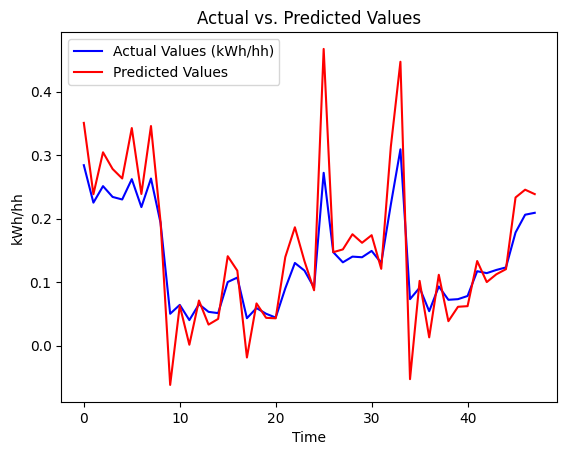

In [110]:
# Plotting Graph to see the day forecast
import matplotlib.pyplot as plt
time_values = np.arange(len(kwh_values_array))

# Plot the actual values (kWh/hh) with blue color and label
plt.plot(time_values, kwh_values_array, color='blue', label='Actual Values (kWh/hh)')

# Plot the predicted values with red color and label
plt.plot(time_values, predicted_values, color='red', label='Predicted Values')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('kWh/hh')
plt.title('Actual vs. Predicted Values')
plt.legend()

# Display the plot
plt.show()

In [111]:
# Create a DataFrame with the actual and predicted values
data = {
    'Actual Values (kWh/hh)': kwh_values_array,
    'Predicted Values': predicted_values
}

df = pd.DataFrame(data)

# Export the DataFrame to a CSV file
df.to_csv('actual_vs_predicted.csv', index=False)